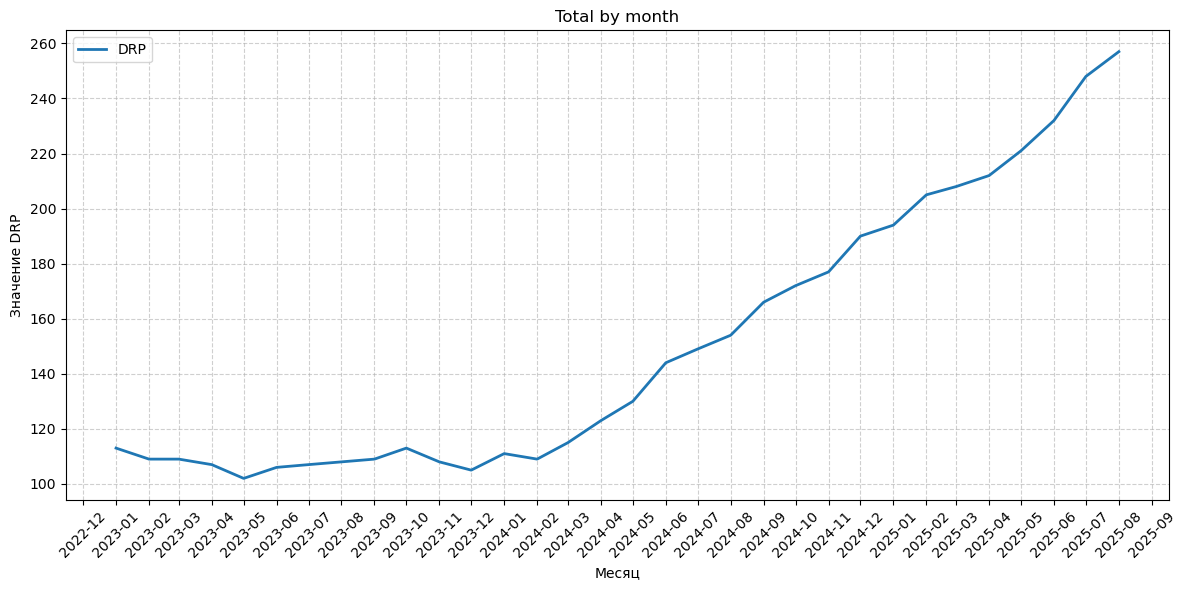

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_excel('arima_drp.xlsx')
df['Date']  = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
df['DRP'] = pd.to_numeric(df['DRP'], errors='coerce')


#ГРАФИК
# 2) убираем битые строки и ставим равномерный месячный индекс
df = df.dropna(subset=['Date', 'DRP']).set_index('Date').asfreq('MS')
# 3) рисуем
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['DRP'], label='DRP', linewidth=2)
# ось X — каждый месяц
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax.set_title('Total by month')
ax.set_xlabel('Месяц'); ax.set_ylabel('Значение DRP')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

In [19]:
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Non-stationary")
    else:
        print("stationary")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['DRP'], 'Counts')

Results of ADF Test on Counts:
ADF Statistic: 4.042872127536936
p-value: 1.0
Non-stationary
Critical Value (1%): -3.661428725118324
Critical Value (5%): -2.960525341210433
Critical Value (10%): -2.6193188033298647




In [21]:

train_size = int(len(df) * 0.75)

train = df.iloc[:train_size]   # первые 80% строк
test  = df.iloc[train_size:]   # последние 20% строк

print("Размер train:", train.shape)
print("Размер test :", test.shape)

Размер train: (24, 1)
Размер test : (8, 1)


In [25]:
# первое дифференцирование
train_diff1 = train["DRP"].diff().dropna()

# проверка снова
print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

ADF p-value после 1 diff: 0.9934296868109654
Results of ADF Test on Train after 1st diff:
ADF Statistic: 0.9267507795725748
p-value: 0.9934296868109654
Non-stationary
Critical Value (1%): -4.068853732362312
Critical Value (5%): -3.1271488757396453
Critical Value (10%): -2.7017297633136095




In [27]:
# второе дифференцирование
train_diff2 = train["DRP"].diff().diff().dropna()

# проверка ADF снова
print("ADF p-value после 2 diff:", adfuller(train_diff2)[1])
test_stationarity(train_diff2, "Train after 2nd diff")

ADF p-value после 2 diff: 1.3640058229895474e-12
Results of ADF Test on Train after 2nd diff:
ADF Statistic: -8.092790488978212
p-value: 1.3640058229895474e-12
stationary
Critical Value (1%): -4.068853732362312
Critical Value (5%): -3.1271488757396453
Critical Value (10%): -2.7017297633136095




<Figure size 800x400 with 0 Axes>

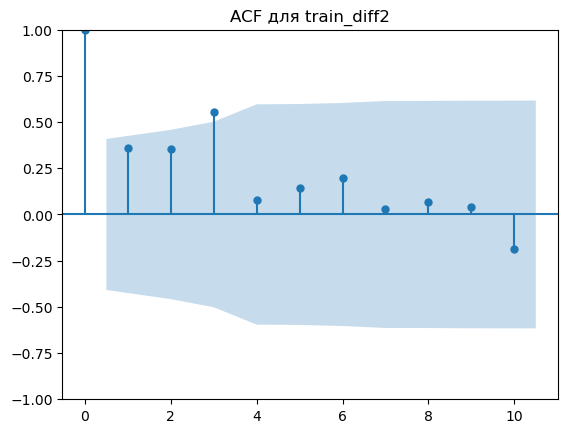

In [29]:
'''
q — это номер последнего “значимого” лага на графике ACF до резкого обрыва.
Если ACF имеет заметные столбики на лагах 1…q и дальше всё внутри синей зоны → MA(q).
Если значимых столбиков нет вообще → q = 0.

Лаг 0 = 1.0 — всегда игнорируем.
Лаги 1–10 — все внутри доверительных границ (синяя зона) → значимых пиков нет.
Для этого ряда после первой разности q = 0 (MA-компонента не требуется).

q = номер последнего подряд значимого лага, после которого ACF резко «обрывается» (остальные внутри зоны).
'''

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plot_acf(train_diff1, lags=10)
plt.title("ACF для train_diff2")
plt.show()

'''
Если ACF резко обрывается после какого-то лага → это порядок q.

Здесь:

лаги 1, 2, 3 значимые,

после 3-го начинается спад, пики становятся меньше.

Значит, модель-кандидат: q ≈ 3 (MA(3)).
'''

<Figure size 800x400 with 0 Axes>

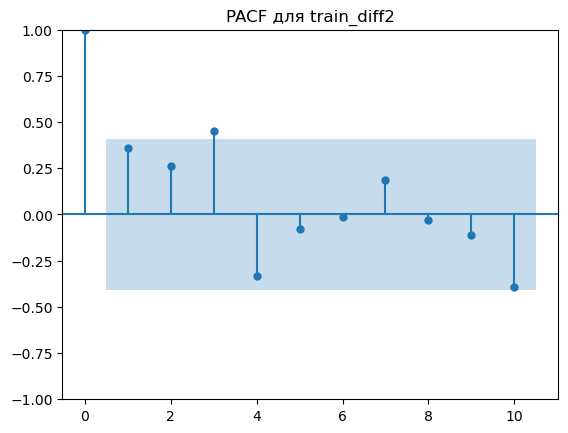

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plot_pacf(train_diff1, lags=10, method="ywm")  # "ywm" – более устойчивая оценка
plt.title("PACF для train_diff2")
plt.show()


C:\Users\eugen\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    DRP   No. Observations:                   24
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 -60.076
Date:                Thu, 18 Sep 2025   AIC                            134.152
Time:                        00:17:08   BIC                            141.789
Sample:                    01-01-2023   HQIC                           135.951
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8667      0.715     -1.213      0.225      -2.268       0.534
ar.L2         -0.6011      0.468     -1.284      0.199      -1.519       0.317
ar.L3         -0.1673      0.372     -0.450      0.6

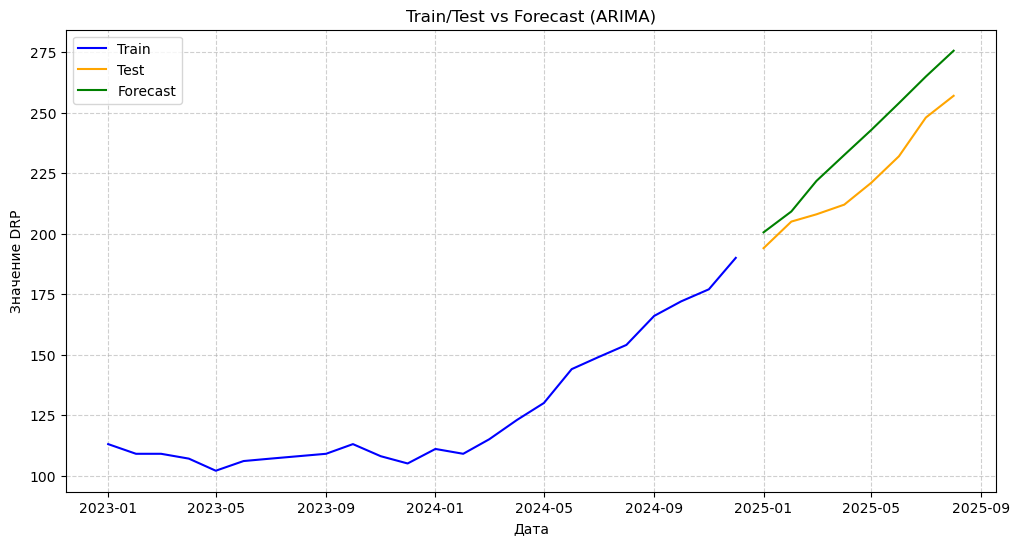

In [37]:
p = 3
d = 2
q = 3

model = ARIMA(train["DRP"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

'''
Log Likelihood → «правдоподобие» модели. Чем выше (ближе к нулю), тем лучше.
AIC, BIC, HQIC → информационные критерии (Akaike, Байеса, Ханнана-Куинна).
Их используют для сравнения нескольких моделей: чем меньше, тем лучше.
'''

#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["DRP"] - forecast) / test["DRP"])) * 100
print(f"MAPE: {mape:.2f}%")


#проверка MAE
y_true = test["DRP"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

#график
plt.figure(figsize=(12,6))
plt.plot(train.index, train["DRP"], label="Train", color="blue")
plt.plot(test.index, test["DRP"], label="Test", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")

plt.title("Train/Test vs Forecast (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Значение DRP")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
#--------------------------------------------
